In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import tensorflow as tf
import tensorflow.contrib.layers as c_layers
import glob
from scipy import misc
from keras.preprocessing.image import ImageDataGenerator

c:\users\vkakerbeck\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\vkakerbeck\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\vkakerbeck\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\vkakerbeck\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:5

Instructions for updating:
Use the retry module or similar alternatives.


Using TensorFlow backend.


In [26]:
path = "./Results/TowerTraining/Recordings/Standard/3999_16.100/"
figure_path = './Results/TowerTraining/Figures/NNFiguresSameOpt/'
obs = np.load(path+"visobs.npy")
vec = np.load(path+"vecobs.npy")
Aval = np.load(path+"values.npy")
actions = np.load(path+"actions.npy")[:,0,:]
enc = np.load(path+"encodings.npy")[:,0,:256]

In [6]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
    directory='C:/Users/vkakerbeck/Dropbox/PhD/Data/ObstacleTower/',
    target_size=(168, 168),
    color_mode="rgb",
    batch_size=256,
    class_mode="input",
    shuffle=True,
    seed=42
)

Found 100195 images belonging to 1 classes.


In [7]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    array = array.flatten() #all values are treated equally, arrays must be 1d
    #array = np.abs(array)# change from original code
    #if np.amin(array) < 0:
     #   array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient


In [22]:
class Agent(object):

    def __init__(self, model_filepath):

        # The file path of model
        self.model_filepath = model_filepath
        # Initialize the model
        self.load_graph(model_filepath = self.model_filepath)

    def load_graph(self, model_filepath):
        '''
        Lode trained model.
        '''
        print('Loading model...')
        self.graph = tf.Graph()

        with tf.gfile.GFile(model_filepath, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())

        #print('Check out the input placeholders:')
        #nodes = [n.name + ' => ' +  n.op for n in graph_def.node if n.op in ('Placeholder')]
        #for node in nodes:
        #    print(node)

        with self.graph.as_default():
            self.VisInput = tf.placeholder(shape=[None, 168, 168, 3], dtype=tf.float32,name="visual_observation_0")
            self.VecInput = tf.placeholder(shape=[None, 8], dtype=tf.float32,name='vector_observation')
            self.action_masks = tf.placeholder(shape=[None, 11], dtype=tf.float32, name="action_masks")
            tf.import_graph_def(graph_def, {'visual_observation_0': self.VisInput,
                                            'vector_observation': self.VecInput,
                                            'action_masks':self.action_masks})
            #self.init = tf.global_variables_initializer()

        self.graph.finalize()

        print('Model loading complete!')

        #Get layer names
        #layers = [op.name for op in self.graph.get_operations()]
        #for layer in layers:
        #    print(layer)
        
        """
        # Check out the weights of the nodes
        weight_nodes = [n for n in graph_def.node if n.op == 'Const']
        for n in weight_nodes:
            print("Name of the node - %s" % n.name)
            # print("Value - " )
            # print(tensor_util.MakeNdarray(n.attr['value'].tensor))
        """

        # In this version, tf.InteractiveSession and tf.Session could be used interchangeably. 
        #self.sess = tf.InteractiveSession(graph = self.graph)
        self.sess = tf.Session(graph = self.graph)
        
        #self.sess.run(self.init)

    def test(self, visIn, vecIn, ActMask):
        #'dense/kernel:0', 'dense_1/kernel:0', 'dense_2/kernel:0', 'dense_3/kernel:0', 'dense_4/kernel:0'

        # Know your output node name
        output_tensor = self.graph.get_tensor_by_name("import/action:0")
        enc_tensor = self.graph.get_tensor_by_name('import/concat:0')
        value_estimate = self.graph.get_tensor_by_name('import/value_estimate:0')
        output = self.sess.run([output_tensor, enc_tensor,value_estimate], feed_dict = {self.VisInput: visIn, self.VecInput: vecIn, self.action_masks: ActMask})

        return output


In [18]:
def test_from_frozen_graph(obs,model_filepath):
    tf.reset_default_graph()
    model = Agent(model_filepath = model_filepath)
    print('loaded')
    
    actOut, enc2, val = model.test(visIn = obs, vecIn= vec[0,:256],ActMask = np.ones((obs.shape[0],11)))
    return actOut, enc2, val

def probsToLabels(probs):
    Ls = []
    for p in probs:
        L = np.zeros(4)
        L[0] = int(np.argmax(p[:3]))
        L[1] = int(np.argmax(p[3:6]))
        L[2] = int(np.argmax(p[6:8]))
        L[3] = int(np.argmax(p[8:]))
        Ls.append(L)
    return np.array(Ls)

#a,e,v = test_from_frozen_graph(obs[:256],'./Results/TowerTraining/models/TowerF4/TowerF4_Baseline-0/LearningBrain/frozen_graph_def.pb')
#actOut2 = probsToLabels(a)

## Predict Actions

In [37]:
tf.reset_default_graph()

def swish(input_activation):
    """Swish activation function. For more info: https://arxiv.org/abs/1710.05941"""
    return tf.multiply(input_activation, tf.nn.sigmoid(input_activation))

o_size_h = 168
o_size_w = 168
vec_obs_size = 8
num_layers = 2
h_size = 256
h_size_vec = 256
            
visual_in = tf.placeholder(shape=[None, o_size_h, o_size_w, 3], dtype=tf.float32,name="visual_observation_0")
labels = tf.placeholder(shape=[None,4], dtype=tf.int64,name="labels")

def create_vector_observation_encoder(observation_input, h_size, activation, num_layers, scope,reuse):
    with tf.variable_scope(scope):
        hidden_vec = observation_input
        for i in range(num_layers):
            hidden_vec = tf.layers.dense(hidden_vec, h_size, activation=activation, reuse=reuse,name="hidden_{}".format(i),kernel_initializer=c_layers.variance_scaling_initializer(1.0))
    return hidden_vec

def create_visual_observation_encoder(image_input, h_size, activation, num_layers, scope,reuse):
    with tf.variable_scope(scope):
        conv1 = tf.layers.conv2d(image_input, 16, kernel_size=[8, 8], strides=[4, 4],activation=tf.nn.elu, reuse=reuse, name="conv_1")
        conv2 = tf.layers.conv2d(conv1, 32, kernel_size=[4, 4], strides=[2, 2],activation=tf.nn.elu, reuse=reuse, name="conv_2")
        hidden_vis = c_layers.flatten(conv2)

    with tf.variable_scope(scope + '/' + 'flat_encoding'):
        hidden_flat = create_vector_observation_encoder(hidden_vis, h_size, activation,num_layers, scope, reuse)
    return hidden_flat

def create_discrete_action_masking_layer(all_logits, action_size):
        """
        Creates a masking layer for the discrete actions
        :param all_logits: The concatenated unnormalized action probabilities for all branches
        :param action_size: A list containing the number of possible actions for each branch
        :return: The action output dimension [batch_size, num_branches] and the concatenated normalized logits
        """
        action_idx = [0] + list(np.cumsum(action_size))
        branches_logits = [all_logits[:, action_idx[i]:action_idx[i + 1]] for i in range(len(action_size))]#split in action branches (size=action_size)
        raw_probs = [tf.nn.softmax(branches_logits[k]) + 1.0e-10 for k in range(len(action_size))]
        normalized_probs = [
            tf.divide(raw_probs[k], tf.reduce_sum(raw_probs[k], axis=1, keepdims=True))
            for k in range(len(action_size))]
        #normalized_probs = raw_probs
        output = tf.concat([tf.multinomial(tf.log(normalized_probs[k]), 1) for k in range(len(action_size))], axis=1)#sample outputs from log probdist
        #output = tf.concat([tf.multinomial(tf.nn.log_softmax(raw_probs[k]), 1) for k in range(len(action_size))], axis=1)#sample outputs from log probdist
        
        log_probs = [tf.log(normalized_probs[k] + 1.0e-10) for k in range(len(action_size))]#xx
        log_probs_flat = tf.concat(log_probs, axis=1)
        return output, log_probs_flat, log_probs

visual_encoders = []

encoded_visual = create_visual_observation_encoder(visual_in,h_size,swish,num_layers,"main_graph_0_encoder0", False)
visual_encoders.append(encoded_visual)
hidden = tf.concat(visual_encoders, axis=1)

class_size = [3,3,2,3]
policy_branches = []
for size in class_size:
    policy_branches.append(tf.layers.dense(hidden, size, activation=tf.nn.relu, use_bias=False,kernel_initializer=c_layers.variance_scaling_initializer(factor=0.01)))

all_log_probs = tf.concat([branch for branch in policy_branches], axis=1, name="action_probs")

output, normalized_logits_flat, norm_logits = create_discrete_action_masking_layer(all_log_probs, class_size)

output = tf.identity(output)
normalized_logits = tf.identity(normalized_logits_flat, name='action')#has nan in places where prob is negative bc it it log(probs)

comparison = tf.equal(labels, output)

accuracy = tf.reduce_mean(tf.cast(comparison, dtype=tf.float32))


#cross_entropies = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = norm_logits, labels = label_cat)
cross_entropiesD = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = norm_logits[0], labels = labels[:,0])
cross_entropiesK = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = norm_logits[1], labels = labels[:,1])
cross_entropiesO = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = norm_logits[2], labels = labels[:,2])
cross_entropiesP = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = norm_logits[3], labels = labels[:,3])
print(cross_entropiesD)

cross_entropies = tf.reduce_mean([cross_entropiesD,cross_entropiesK,cross_entropiesO,cross_entropiesP],axis=1)
print(cross_entropies)
# Calculate the mean cross entropy for the mini-batch 
mean_cross_entropy = tf.reduce_mean(cross_entropies)
# Define optimizer and minimize the mean cross entropy 
#optimizer = tf.train.AdamOptimizer(0.001)#original
optimizer = tf.train.AdamOptimizer(0.0001)

#gradients = optimizer.compute_gradients(mean_cross_entropy)
gradients = optimizer.compute_gradients(mean_cross_entropy)
#training_step = optimizer.minimize(mean_scaled_error)
training_step = optimizer.minimize(mean_cross_entropy)

saver = tf.train.Saver()

Tensor("SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:0", shape=(?,), dtype=float32)
Tensor("Mean_1:0", shape=(4,), dtype=float32)


In [38]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

Allentropies = []
Allaccuracies = []
AllGinis = []
LastSave = 0

epochs = 100
model = Agent(model_filepath = './Results/TowerTraining/models/TowerF4/TowerF4_Baseline-0/LearningBrain/frozen_graph_def.pb')
print('loaded')
    
for i in range(epochs):
    count = 0
    Testentro,  Testaccu,TestEnc = sess.run([mean_cross_entropy, accuracy, encoded_visual], feed_dict = {visual_in: obs, labels: actions})
    print('Test:  '+str(Testentro)+ ' - '+str(Testaccu)+ ' - Gini: ' + str(np.round(gini(np.abs(TestEnc)),3)))
    AllGinis.append(gini(np.abs(TestEnc)))
    #if Valaccu >np.max(AllValaccuracies):
    #    saver.save(sess, "./Results/TowerTraining/Classifier/Model_lr0001/model.ckpt")
    #    print('saved model')
    #    LastSave = i-1
    for batchX, _ in train_generator:
        #batchy, _ = test_from_frozen_graph(batchX,'./Results/TowerTraining/models/TowerF4/TowerF4_Baseline-0/LearningBrain/frozen_graph_def.pb')
        batchy, _ = model.test(visIn = batchX, vecIn= vec[0,:batchX.shape[0]],ActMask = np.ones((batchX.shape[0],11)))
        batchy = probsToLabels(batchy)
        entropies = []
        accuracies = []
        scaled_errs = []
        entro, accu,comp, _ = sess.run([mean_cross_entropy, accuracy, comparison,training_step], feed_dict = {visual_in: batchX, labels: batchy})
        #print(accu)
        entropies.append(entro)
        accuracies.append(accu)
        #print(str(entro)+' - '+str(accu))
        if count>126:
            Allentropies.append(entropies)
            Allaccuracies.append(accuracies)
            break
        count = count+1

Loading model...
Model loading complete!
loaded
Test:  0.9974288 - 0.380875 - Gini: 0.433
Test:  0.44076204 - 0.724875 - Gini: 0.684
Test:  0.4247903 - 0.7476875 - Gini: 0.636
Test:  0.4028906 - 0.772625 - Gini: 0.621
Test:  0.39239573 - 0.7836875 - Gini: 0.623
Test:  0.38057745 - 0.779625 - Gini: 0.62
Test:  0.373269 - 0.7909375 - Gini: 0.617
Test:  0.37107915 - 0.794625 - Gini: 0.617
Test:  0.3674817 - 0.7886875 - Gini: 0.616
Test:  0.36202013 - 0.7905625 - Gini: 0.614
Test:  0.3603158 - 0.790125 - Gini: 0.614
Test:  0.36274904 - 0.7889375 - Gini: 0.614
Test:  0.35732728 - 0.79325 - Gini: 0.612
Test:  0.35547426 - 0.787875 - Gini: 0.605
Test:  0.35584086 - 0.7936875 - Gini: 0.608
Test:  0.3586415 - 0.8025 - Gini: 0.608
Test:  0.35232285 - 0.7988125 - Gini: 0.605
Test:  0.35179496 - 0.7953125 - Gini: 0.601
Test:  0.35020742 - 0.794375 - Gini: 0.596
Test:  0.35028815 - 0.7965 - Gini: 0.6
Test:  0.34979153 - 0.7965625 - Gini: 0.598
Test:  0.34880346 - 0.7938125 - Gini: 0.598
Test:  0.34

In [51]:
np.save(path+'supervisedAGinis.npy',AllGinis)
np.save(path+'supervisedAAcc.npy',Allaccuracies)

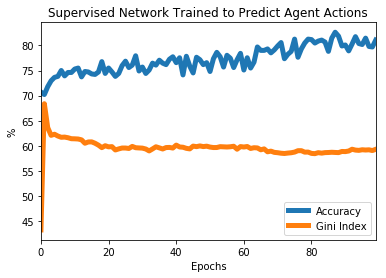

In [50]:
plt.figure()
plt.plot(np.array(Allaccuracies)*100,lw=5)
plt.plot(np.array(AllGinis)*100,lw=5)
plt.title('Supervised Network Trained to Predict Agent Actions')
plt.xlabel('Epochs')
plt.ylabel('%')
plt.xlim([0,99])
plt.legend(['Accuracy','Gini Index'],loc=4)
#plt.show()
plt.savefig(figure_path+'supervised_agent.eps', bbox_inches='tight',dpi=300)

## Predict Actions & Values

In [34]:
tf.reset_default_graph()

def swish(input_activation):
    """Swish activation function. For more info: https://arxiv.org/abs/1710.05941"""
    return tf.multiply(input_activation, tf.nn.sigmoid(input_activation))

o_size_h = 168
o_size_w = 168
vec_obs_size = 8
num_layers = 2
h_size = 256
h_size_vec = 256
            
visual_in = tf.placeholder(shape=[None, o_size_h, o_size_w, 3], dtype=tf.float32,name="visual_observation_0")
labels = tf.placeholder(shape=[None,4], dtype=tf.int64,name="labels")
values = tf.placeholder(shape=[None,1], dtype=tf.int64,name="values")

def create_vector_observation_encoder(observation_input, h_size, activation, num_layers, scope,reuse):
    with tf.variable_scope(scope):
        hidden_vec = observation_input
        for i in range(num_layers):
            hidden_vec = tf.layers.dense(hidden_vec, h_size, activation=activation, reuse=reuse,name="hidden_{}".format(i),kernel_initializer=c_layers.variance_scaling_initializer(1.0))
    return hidden_vec

def create_visual_observation_encoder(image_input, h_size, activation, num_layers, scope,reuse):
    with tf.variable_scope(scope):
        conv1 = tf.layers.conv2d(image_input, 16, kernel_size=[8, 8], strides=[4, 4],activation=tf.nn.elu, reuse=reuse, name="conv_1")
        conv2 = tf.layers.conv2d(conv1, 32, kernel_size=[4, 4], strides=[2, 2],activation=tf.nn.elu, reuse=reuse, name="conv_2")
        hidden_vis = c_layers.flatten(conv2)

    with tf.variable_scope(scope + '/' + 'flat_encoding'):
        hidden_flat = create_vector_observation_encoder(hidden_vis, h_size, activation,num_layers, scope, reuse)
    return hidden_flat

def create_discrete_action_masking_layer(all_logits, action_size):
        """
        Creates a masking layer for the discrete actions
        :param all_logits: The concatenated unnormalized action probabilities for all branches
        :param action_size: A list containing the number of possible actions for each branch
        :return: The action output dimension [batch_size, num_branches] and the concatenated normalized logits
        """
        action_idx = [0] + list(np.cumsum(action_size))
        branches_logits = [all_logits[:, action_idx[i]:action_idx[i + 1]] for i in range(len(action_size))]#split in action branches (size=action_size)
        raw_probs = [tf.nn.softmax(branches_logits[k]) + 1.0e-10 for k in range(len(action_size))]
        normalized_probs = [
            tf.divide(raw_probs[k], tf.reduce_sum(raw_probs[k], axis=1, keepdims=True))
            for k in range(len(action_size))]
        #normalized_probs = raw_probs
        output = tf.concat([tf.multinomial(tf.log(normalized_probs[k]), 1) for k in range(len(action_size))], axis=1)#sample outputs from log probdist
        #output = tf.concat([tf.multinomial(tf.nn.log_softmax(raw_probs[k]), 1) for k in range(len(action_size))], axis=1)#sample outputs from log probdist
        
        log_probs = [tf.log(normalized_probs[k] + 1.0e-10) for k in range(len(action_size))]#xx
        log_probs_flat = tf.concat(log_probs, axis=1)
        return output, log_probs_flat, log_probs

visual_encoders = []

encoded_visual = create_visual_observation_encoder(visual_in,h_size,swish,num_layers,"main_graph_0_encoder0", False)
visual_encoders.append(encoded_visual)
hidden = tf.concat(visual_encoders, axis=1)

class_size = [3,3,2,3]
policy_branches = []
for size in class_size:
    policy_branches.append(tf.layers.dense(hidden, size, activation=tf.nn.relu, use_bias=False,kernel_initializer=c_layers.variance_scaling_initializer(factor=0.01)))

all_log_probs = tf.concat([branch for branch in policy_branches], axis=1, name="action_probs")

output, normalized_logits_flat, norm_logits = create_discrete_action_masking_layer(all_log_probs, class_size)

output = tf.identity(output)

value = tf.layers.dense(hidden, 1, activation=None)
normalized_logits = tf.identity(normalized_logits_flat, name='action')#has nan in places where prob is negative bc it it log(probs)

comparison = tf.equal(labels, output)

accuracy = tf.reduce_mean(tf.cast(comparison, dtype=tf.float32))


#cross_entropies = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = norm_logits, labels = label_cat)
cross_entropiesD = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = norm_logits[0], labels = labels[:,0])
cross_entropiesK = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = norm_logits[1], labels = labels[:,1])
cross_entropiesO = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = norm_logits[2], labels = labels[:,2])
cross_entropiesP = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = norm_logits[3], labels = labels[:,3])
print(cross_entropiesD)

cross_entropies = tf.reduce_mean([cross_entropiesD,cross_entropiesK,cross_entropiesO,cross_entropiesP],axis=1)
print(cross_entropies)
# Calculate the mean cross entropy for the mini-batch 
mean_cross_entropy = tf.reduce_mean(cross_entropies)
value_error = tf.losses.mean_squared_error(values,value)
# Define optimizer and minimize the mean cross entropy 
#optimizer = tf.train.AdamOptimizer(0.001)#original
optimizer = tf.train.AdamOptimizer(0.0001)

#gradients = optimizer.compute_gradients(mean_cross_entropy)
gradients = optimizer.compute_gradients(mean_cross_entropy)
#training_step = optimizer.minimize(mean_scaled_error)
training_step = optimizer.minimize(mean_cross_entropy+value_error)

saver = tf.train.Saver()

Tensor("SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:0", shape=(?,), dtype=float32)
Tensor("Mean_1:0", shape=(4,), dtype=float32)


In [35]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

Allentropies = []
Allaccuracies = []
AllValueLosses = []
AllGinis = []
LastSave = 0

epochs = 100
model = Agent(model_filepath = './Results/TowerTraining/models/TowerF4/TowerF4_Baseline-0/LearningBrain/frozen_graph_def.pb')
print('loaded')
    
for i in range(epochs):
    count = 0
    Testentro,  Testaccu,TestValE,TestEnc = sess.run([mean_cross_entropy, accuracy,value_error, encoded_visual], feed_dict = {visual_in: obs, labels: actions, values: Aval[:,:,0]})
    print('Test:  '+str(Testentro)+ ' - '+str(Testaccu)+' - Value Error: '+str(TestValE)+ ' - Gini: ' + str(np.round(gini(np.abs(TestEnc)),3)))
    AllGinis.append(gini(np.abs(TestEnc)))
    #if Valaccu >np.max(AllValaccuracies):
    #    saver.save(sess, "./Results/TowerTraining/Classifier/Model_lr0001/model.ckpt")
    #    print('saved model')
    #    LastSave = i-1
    for batchX, _ in train_generator:
        #batchy, _ = test_from_frozen_graph(batchX,'./Results/TowerTraining/models/TowerF4/TowerF4_Baseline-0/LearningBrain/frozen_graph_def.pb')
        batchy, _,vals = model.test(visIn = batchX, vecIn= vec[0,:batchX.shape[0]],ActMask = np.ones((batchX.shape[0],11)))
        batchy = probsToLabels(batchy)
        entropies = []
        accuracies = []
        scaled_errs = []
        val_errs = []
        entro, accu,valErr,comp, _ = sess.run([mean_cross_entropy, accuracy,value_error, comparison,training_step], feed_dict = {visual_in: batchX, labels: batchy, values: vals})
        #print(accu)
        entropies.append(entro)
        accuracies.append(accu)
        val_errs.append(valErr)
        #print(str(entro)+' - '+str(accu))
        if count>126:
            Allentropies.append(entropies)
            Allaccuracies.append(accuracies)
            AllValueLosses.append(val_errs)
            print(np.mean(val_errs))
            break
        count = count+1

Loading model...
Model loading complete!
loaded
Test:  0.99741757 - 0.3711875 - Value Error: 8.387664 - Gini: 0.427
0.41843665
Test:  0.5121099 - 0.6696875 - Value Error: 21.945465 - Gini: 0.572
0.41254824
Test:  0.4536705 - 0.731625 - Value Error: 21.989578 - Gini: 0.596
0.40655875
Test:  0.45425957 - 0.7240625 - Value Error: 21.90395 - Gini: 0.604
0.3998593
Test:  0.45129782 - 0.7289375 - Value Error: 21.770626 - Gini: 0.609
0.41505718
Test:  0.45098588 - 0.7238125 - Value Error: 22.325102 - Gini: 0.611
0.39215058
Test:  0.4519164 - 0.72975 - Value Error: 22.042988 - Gini: 0.614
0.39081877
Test:  0.44945794 - 0.7316875 - Value Error: 21.755978 - Gini: 0.617
0.38846555
Test:  0.4483517 - 0.7325 - Value Error: 22.076712 - Gini: 0.613
0.4028511
Test:  0.4466684 - 0.7333125 - Value Error: 22.408426 - Gini: 0.615
0.40885106
Test:  0.4479059 - 0.7353125 - Value Error: 21.909828 - Gini: 0.615
0.41712916
Test:  0.43903404 - 0.737 - Value Error: 21.99125 - Gini: 0.621
0.3992083
Test:  0.43290

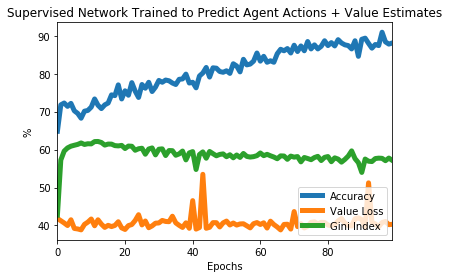

In [41]:
plt.figure()
plt.plot(np.array(Allaccuracies)*100,lw=5)
plt.plot(np.array(AllValueLosses)*100,lw=5)
plt.plot(np.array(AllGinis)*100,lw=5)
plt.title('Supervised Network Trained to Predict Agent Actions + Value Estimates')
plt.xlabel('Epochs')
plt.ylabel('%')
plt.xlim([0,99])
plt.legend(['Accuracy','Value Loss','Gini Index'],loc=4)
#plt.show()
plt.savefig(figure_path+'supervised_agent_val.png', bbox_inches='tight',dpi=300)

## Predict Rewards (Not Done)

In [89]:
tf.reset_default_graph()

def swish(input_activation):
    """Swish activation function. For more info: https://arxiv.org/abs/1710.05941"""
    return tf.multiply(input_activation, tf.nn.sigmoid(input_activation))

o_size_h = 168
o_size_w = 168
vec_obs_size = 8
num_layers = 2
h_size = 256
h_size_vec = 256
            
visual_in = tf.placeholder(shape=[None, o_size_h, o_size_w, 3], dtype=tf.float32,name="visual_observation_0")
labels = tf.placeholder(shape=[None,4], dtype=tf.int64,name="labels")
reward = tf.placeholder(shape=[None,1], dtype=tf.float32,name="reward")

def create_vector_observation_encoder(observation_input, h_size, activation, num_layers, scope,reuse):
    with tf.variable_scope(scope):
        hidden_vec = observation_input
        for i in range(num_layers):
            hidden_vec = tf.layers.dense(hidden_vec, h_size, activation=activation, reuse=reuse,name="hidden_{}".format(i),kernel_initializer=c_layers.variance_scaling_initializer(1.0))
    return hidden_vec

def create_visual_observation_encoder(image_input, h_size, activation, num_layers, scope,reuse):
    with tf.variable_scope(scope):
        conv1 = tf.layers.conv2d(image_input, 16, kernel_size=[8, 8], strides=[4, 4],activation=tf.nn.elu, reuse=reuse, name="conv_1")
        conv2 = tf.layers.conv2d(conv1, 32, kernel_size=[4, 4], strides=[2, 2],activation=tf.nn.elu, reuse=reuse, name="conv_2")
        hidden_vis = c_layers.flatten(conv2)

    with tf.variable_scope(scope + '/' + 'flat_encoding'):
        hidden_flat = create_vector_observation_encoder(hidden_vis, h_size, activation,num_layers, scope, reuse)
    return hidden_flat

def create_discrete_action_masking_layer(all_logits, action_size):
        """
        Creates a masking layer for the discrete actions
        :param all_logits: The concatenated unnormalized action probabilities for all branches
        :param action_size: A list containing the number of possible actions for each branch
        :return: The action output dimension [batch_size, num_branches] and the concatenated normalized logits
        """
        action_idx = [0] + list(np.cumsum(action_size))
        branches_logits = [all_logits[:, action_idx[i]:action_idx[i + 1]] for i in range(len(action_size))]#split in action branches (size=action_size)
        raw_probs = [tf.nn.softmax(branches_logits[k]) + 1.0e-10 for k in range(len(action_size))]
        normalized_probs = [
            tf.divide(raw_probs[k], tf.reduce_sum(raw_probs[k], axis=1, keepdims=True))
            for k in range(len(action_size))]
        #normalized_probs = raw_probs
        output = tf.concat([tf.multinomial(tf.log(normalized_probs[k]), 1) for k in range(len(action_size))], axis=1)#sample outputs from log probdist
        #output = tf.concat([tf.multinomial(tf.nn.log_softmax(raw_probs[k]), 1) for k in range(len(action_size))], axis=1)#sample outputs from log probdist
        
        log_probs = [tf.log(normalized_probs[k] + 1.0e-10) for k in range(len(action_size))]#xx
        log_probs_flat = tf.concat(log_probs, axis=1)
        return output, log_probs_flat, log_probs

visual_encoders = []

encoded_visual = create_visual_observation_encoder(visual_in,h_size,swish,num_layers,"main_graph_0_encoder0", False)
visual_encoders.append(encoded_visual)
hidden = tf.concat(visual_encoders, axis=1)

class_size = [3,3,2,3]
policy_branches = []
for size in class_size:
    policy_branches.append(tf.layers.dense(hidden, size, activation=tf.nn.relu, use_bias=False,kernel_initializer=c_layers.variance_scaling_initializer(factor=0.01)))

all_log_probs = tf.concat([branch for branch in policy_branches], axis=1, name="action_probs")

output, normalized_logits_flat, norm_logits = create_discrete_action_masking_layer(all_log_probs, class_size)

output = tf.identity(output)
normalized_logits = tf.identity(normalized_logits_flat, name='action')#has nan in places where prob is negative bc it it log(probs)

comparison = tf.equal(labels, output)

accuracy = tf.reduce_mean(tf.cast(comparison, dtype=tf.float32))

optimizer = tf.train.AdamOptimizer(0.0001)

cross_entropiesD = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = norm_logits[0], labels = labels[:,0])
cross_entropiesK = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = norm_logits[1], labels = labels[:,1])
cross_entropiesO = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = norm_logits[2], labels = labels[:,2])
cross_entropiesP = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = norm_logits[3], labels = labels[:,3])

cross_entropies = tf.reduce_mean([cross_entropiesD,cross_entropiesK,cross_entropiesO,cross_entropiesP],axis=1)
mean_cross_entropy = tf.reduce_mean(cross_entropies)

gradients = optimizer.compute_gradients(reward)
#training_step = optimizer.minimize(mean_scaled_error)
training_step = optimizer.minimize(-reward+0*mean_cross_entropy)

saver = tf.train.Saver()

In [90]:
def getRewards(out,labels):
    reward = np.zeros((out.shape[0],1))
    for i,o in enumerate(out):
        if np.all(o==labels[i]):
            reward[i] = 1
            #reward = reward +1
    return reward

In [91]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

AllaccuraciesR = []
AllGinisR = []
LastSave = 0

epochs = 100
model = Agent(model_filepath = './Results/TowerTraining/models/TowerF4/TowerF4_Baseline-0/LearningBrain/frozen_graph_def.pb')
print('loaded')
    
for i in range(epochs):
    count = 0
    Testentro,  Testaccu,TestEnc = sess.run([mean_cross_entropy, accuracy, encoded_visual], feed_dict = {visual_in: obs, labels: actions})
    print('Test:  '+str(Testentro)+ ' - '+str(Testaccu)+ ' - Gini: ' + str(np.round(gini(np.abs(TestEnc)),3)))
    AllGinisR.append(gini(np.abs(TestEnc)))

    for batchX, _ in train_generator:
        batchy, _ = model.test(visIn = batchX, vecIn= vec[0,:batchX.shape[0]],ActMask = np.ones((batchX.shape[0],11)))
        batchy = probsToLabels(batchy)

        accuracies = []
        scaled_errs = []
        accu,comp,out,probs = sess.run([accuracy, comparison,output,normalized_logits_flat], feed_dict = {visual_in: batchX, labels: batchy, reward:np.ones((batchy.shape[0],1))})
        #probs are the same but outpus are different bc it draws randomly each time from the prob-dist.
        #need to decide if its better to use max(probs) for rewards or just the random draws from the first test.
        #for not i take the outputs bc it seems closer to how the RL agent learns.
        r = getRewards(out,batchy)
        #print(np.sum(r))
        _ = sess.run([training_step], feed_dict = {visual_in: batchX, labels: batchy, reward:r})
        #print(accu)
        accuracies.append(accu)
        #print(str(entro)+' - '+str(accu))
        if count>126:
            AllaccuraciesR.append(accuracies)
            break
        count = count+1

Loading model...
Model loading complete!
loaded
Test:  0.9974513 - 0.370125 - Gini: 0.424
Test:  0.9974513 - 0.3740625 - Gini: 0.424


KeyboardInterrupt: 